# Testing VAEAC
Let's test the existing code from the original implementation.

### Setup

In [1]:
# Updated notebook code using existing training infrastructure
# Add these at the VERY TOP of your notebook
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'  # Disable macOS fork safety
os.environ['PYTHONUNBUFFERED'] = '1'  # Better logging

import torch
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)  # Required for macOS

import torch
import torchvision
import matplotlib.pyplot as plt
from VAEAC.MNISTconv_bern import VAEAC_bern_net
from VAEAC.train import train_VAEAC  # Use existing training function
from src.masks import top_masker  # Use existing mask generator

# Configuration
config = {
    'input_dim': 784,
    'latent_dim': 20,
    'batch_size': 128,
    'epochs': 50,
    'lr': 3e-4,
    'cuda': torch.cuda.is_available(),
    'Nclass': 10,  # Enable joint (x,y) modeling
    'num_workers': min(4, os.cpu_count()//2),  # Use at most 4 workers
    'persistent_workers': True,  # Required for stability
    'multiprocessing_context': 'spawn'  # Explicit context
}

Successfully imported from src!


### 1. Load MNIST Data

In [2]:
class FlattenTransform(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)

# Replace the lambda with this class
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    FlattenTransform()  # Now pickleable
])

# Rest of the code remains the same
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform  # Use modified transform, 
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform  # Use modified transform, 
)

# Create DataLoader with macOS-specific settings
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    persistent_workers=config['persistent_workers'],
    multiprocessing_context=config['multiprocessing_context'],
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    persistent_workers=config['persistent_workers'],
    multiprocessing_context=config['multiprocessing_context'],
    pin_memory=True
)

### 2. Initialize Model using existing class


In [3]:
model = VAEAC_bern_net(
    input_dim=config['input_dim'] + config['Nclass'],
    latent_dim=config['latent_dim'],
    lr=config['lr'],
    targets=True,  # Critical for joint modeling
)


Net:
VAE_bern_net
Using device: mps
    Total params: 2.71M


### 3. Use existing mask generator with label preservation

In [4]:
class JointMasker:
    def __init__(self, base_masker):
        self.base_masker = base_masker
        
    def __call__(self, x):
        mask = self.base_masker(x[:, :-10])
        full_mask = torch.cat([mask, torch.ones(x.size(0), 10).bool()], 1)
        return full_mask
    
    def __getstate__(self):
        # Needed for proper pickling
        return self.__dict__
    
    def __setstate__(self, d):
        # Needed for proper unpickling
        self.__dict__ = d

masker = JointMasker(top_masker(p=0.8))  # Use existing top_masker

### 4. Train using existing train_VAEAC function


Network:

Train:
  init cost variables:


Epoch 1/50:   0%|          | 0/468 [00:00<?, ?it/s]/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/OldStuff/src/radam.py:73: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1642.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Epoch 1/50: 469it [02:43,  2.87it/s, vlb=-240.5128]                         


Epoch 1/50, vlb -240.5128, time: 163.40s
    vlb -130.560788 (-inf)



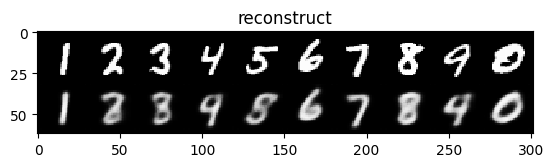

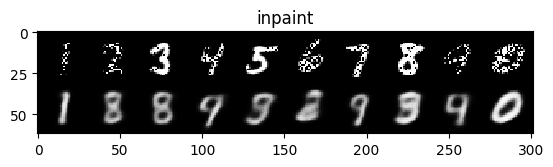

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 2/50: 469it [02:41,  2.91it/s, vlb=-124.7802]                         


Epoch 2/50, vlb -124.7802, time: 161.33s
    vlb -101.677819 (-130.560788)



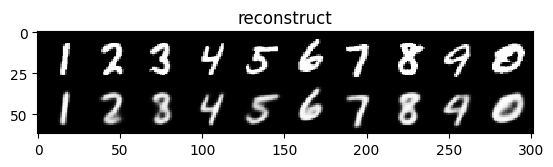

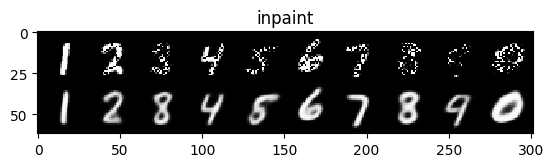

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 3/50: 469it [02:39,  2.94it/s, vlb=-105.2139]                         


Epoch 3/50, vlb -105.2139, time: 159.64s
    vlb -90.526572 (-101.677819)



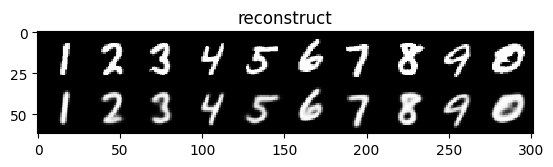

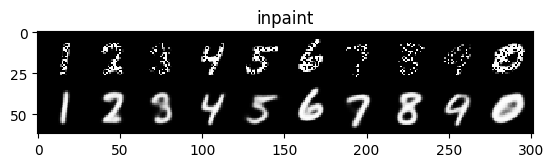

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 4/50: 469it [02:39,  2.93it/s, vlb=-96.3482]                         


Epoch 4/50, vlb -96.3482, time: 159.99s
    vlb -84.231618 (-90.526572)



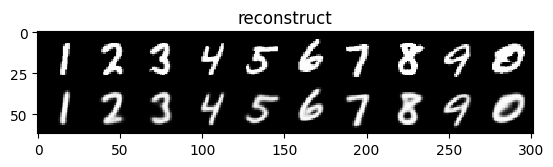

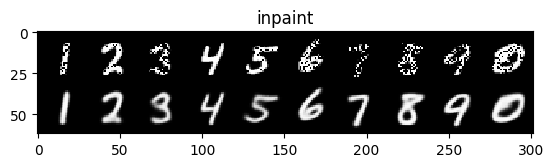

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 5/50: 469it [02:40,  2.93it/s, vlb=-90.6512]                         


Epoch 5/50, vlb -90.6512, time: 160.22s
    vlb -83.780036 (-84.231618)



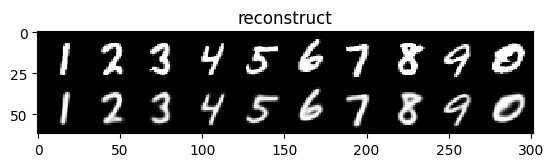

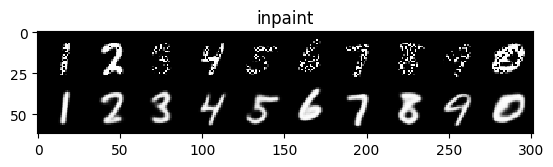

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 6/50: 469it [02:36,  2.99it/s, vlb=-86.6618]                         


Epoch 6/50, vlb -86.6618, time: 156.67s
    vlb -77.483950 (-83.780036)



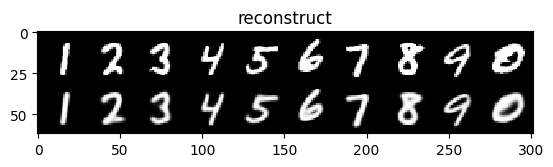

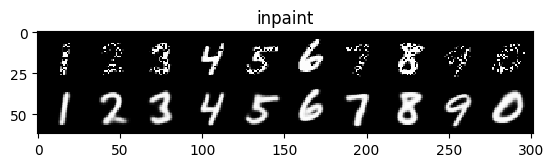

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 7/50: 469it [02:35,  3.01it/s, vlb=-84.2167]                         


Epoch 7/50, vlb -84.2167, time: 155.94s
    vlb -76.292106 (-77.483950)



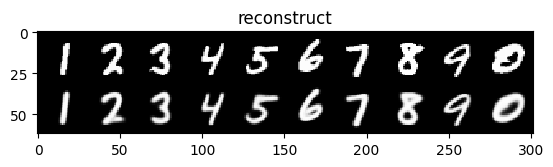

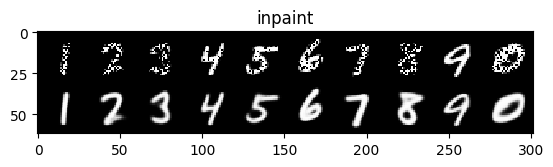

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 8/50: 469it [02:35,  3.01it/s, vlb=-82.1828]                         


Epoch 8/50, vlb -82.1828, time: 155.87s
    vlb -74.480981 (-76.292106)



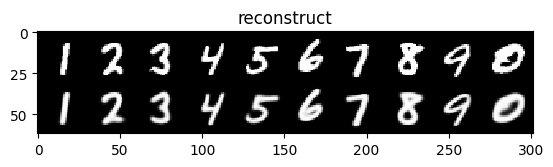

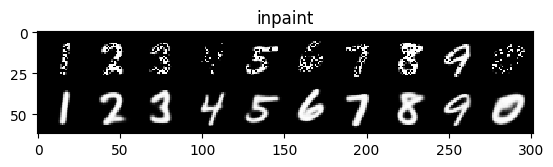

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 9/50: 469it [02:36,  3.00it/s, vlb=-80.9341]                         


Epoch 9/50, vlb -80.9341, time: 156.53s
    vlb -73.978868 (-74.480981)



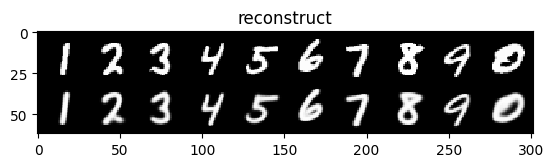

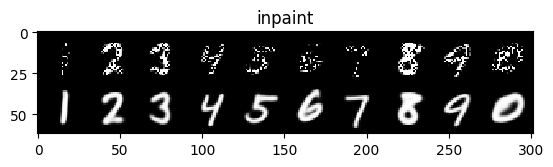

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 10/50: 469it [02:35,  3.01it/s, vlb=-79.2824]                         


Epoch 10/50, vlb -79.2824, time: 155.64s
    vlb -73.798077 (-73.978868)



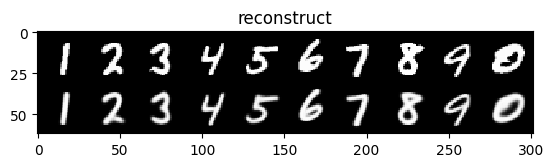

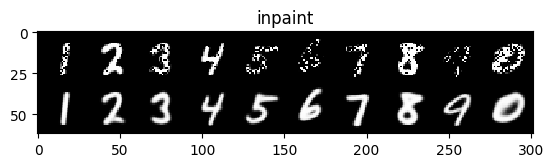

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 11/50: 469it [02:35,  3.01it/s, vlb=-78.1555]                         


Epoch 11/50, vlb -78.1555, time: 155.88s
    vlb -72.325084 (-73.798077)



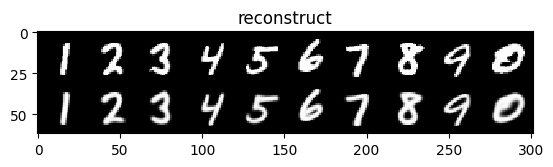

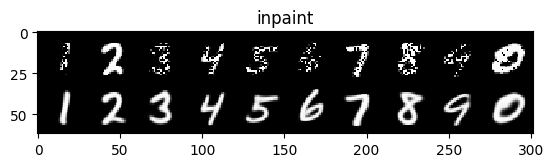

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 12/50: 469it [02:36,  3.00it/s, vlb=-77.0963]                         


Epoch 12/50, vlb -77.0963, time: 156.57s
    vlb -71.231804 (-72.325084)



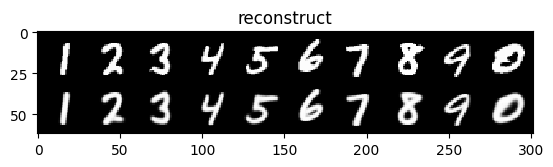

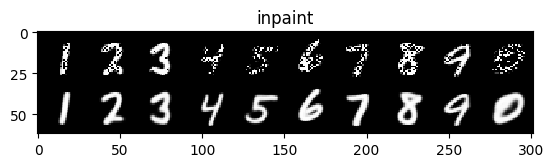

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 13/50: 469it [02:36,  3.00it/s, vlb=-76.1192]                         


Epoch 13/50, vlb -76.1192, time: 156.13s
    vlb -70.863532 (-71.231804)



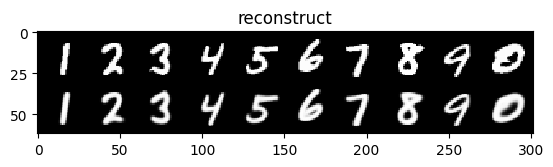

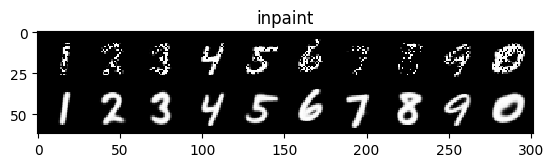

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 14/50: 469it [02:35,  3.01it/s, vlb=-75.4314]                         


Epoch 14/50, vlb -75.4314, time: 155.89s
    vlb -70.625930 (-70.863532)



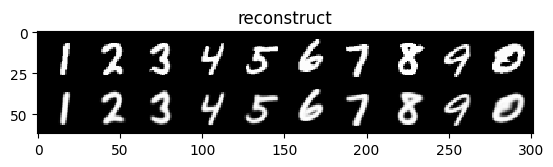

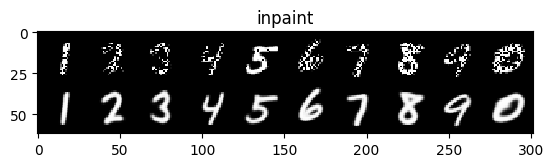

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 15/50: 469it [02:36,  2.99it/s, vlb=-74.7252]                         


Epoch 15/50, vlb -74.7252, time: 156.73s
    vlb -70.519508 (-70.625930)



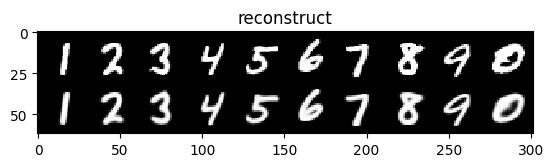

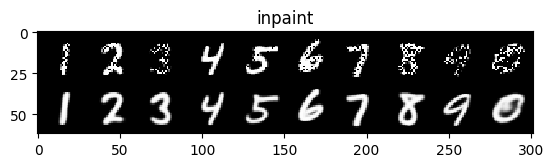

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 16/50: 469it [02:36,  3.00it/s, vlb=-73.9754]                         


Epoch 16/50, vlb -73.9754, time: 156.29s
    vlb -69.904726 (-70.519508)



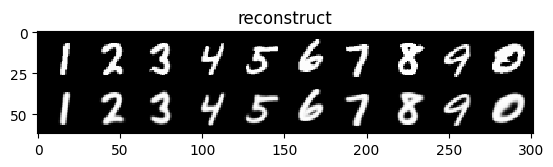

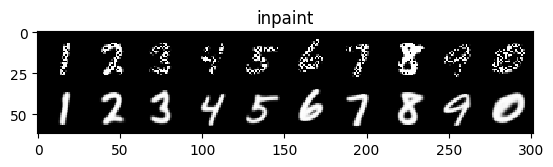

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 17/50: 469it [02:36,  3.00it/s, vlb=-73.5427]                         


Epoch 17/50, vlb -73.5427, time: 156.13s
    vlb -68.161875 (-69.904726)



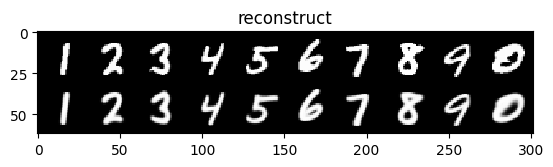

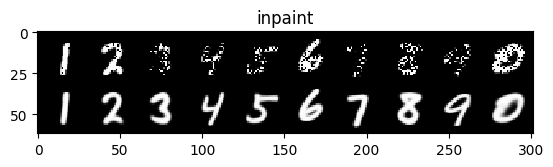

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 18/50: 469it [02:36,  3.00it/s, vlb=-73.0053]                         


Epoch 18/50, vlb -73.0053, time: 156.45s
    vlb -68.043795 (-68.161875)



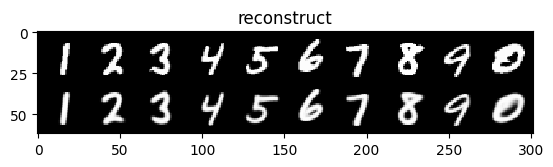

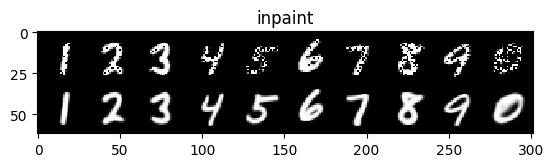

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 19/50:  35%|███▍      | 163/468 [00:58<02:09,  2.35it/s, vlb=-72.7934]

KeyboardInterrupt: 

In [5]:
save_dir = './vaeac_mnist'
vlb_train, vlb_dev = train_VAEAC(
    net=model,
    masker=masker,
    name=save_dir,
    batch_size=config['batch_size'],
    nb_epochs=config['epochs'],
    trainset=train_dataset,
    valset=test_dataset,
    cuda=config['cuda'],
    flat_ims=True,
    train_plot=True,
    Nclass=config['Nclass'],
    early_stop=10
)

### 5. Visualization using existing model methods

In [ ]:
def plot_reconstructions(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5)
    x, y = next(iter(test_loader))
    
    # Create sample mask
    mask = masker(torch.cat([x, torch.zeros(5,10)], 1))  # Dummy labels
    
    with torch.no_grad():
        rec = model.inpaint(x, mask, Nsample=1)[0]

    # Plotting code remains the same
    fig, axs = plt.subplots(2, 5, figsize=(15,4))
    for i in range(5):
        axs[0,i].imshow(x[i].view(28,28), cmap='gray')
        axs[1,i].imshow(rec[i].view(28,28), cmap='gray')
    plt.show()

plot_reconstructions(model, test_dataset)